In [1]:
import numpy as np
from scipy import spatial
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import pandas as pd
import re
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Exercises week 11 - word embedding

Word embeddings are very popular representations for the vocabulary of any document corpus. It is one of the major breakthroughs of utilizing deep learning to solve challenging problems in natural language processing. A word embedding is a learned representation for the text, in which the words that have similar meaning have a similar representation. This meaning can be based varius aspects such as syntax, semantics and abstract relations between words.

For this exercise we use pre-trained word embedding from the GloVe (Global Vectors for Word Representation, https://nlp.stanford.edu/projects/glove/) project. In particular we use data trained on the socalled Wikipedia 2014 and Gigaword 5 corpus. This dataset contains $400000$ words, each represented by a feature vector (http://nlp.stanford.edu/data/glove.6B.zip). 

# Exercise 1 - Co-occurrence matrix



In [2]:
data    = pd.read_csv("Reviews.csv")
reviews = data["Text"].values[:4] # take only first couple of reviews

**1. Create a list of all the words in the review**
- loop over all words in each review
- save only the distinct words in a list
- remember to convert all words to lower characters using ".lower()" on strings

In [5]:
words_in_review = []
for review in reviews:
    words_in_review.extend(review.lower().split())
print(words_in_review)

['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality.', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better.', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most.', 'product', 'arrived', 'labeled', 'as', 'jumbo', 'salted', 'peanuts...the', 'peanuts', 'were', 'actually', 'small', 'sized', 'unsalted.', 'not', 'sure', 'if', 'this', 'was', 'an', 'error', 'or', 'if', 'the', 'vendor', 'intended', 'to', 'represent', 'the', 'product', 'as', '"jumbo".', 'this', 'is', 'a', 'confection', 'that', 'has', 'been', 'around', 'a', 'few', 'centuries.', 'it', 'is', 'a', 'light,', 'pillowy', 'citrus', 'gelatin', 'with', 'nuts', '-', 'in', 'this', 'case', 'filberts.', 'and', 'it', 'is', 'cut', 'into', 'tiny', 'squares', 'and', 'then', 'liberally', 'coated', 'with', 'p

**3. Calculate the co-occurrence matrix $X_{ij}$**
- Initialise a default dictionary with the Counter object
- Iterate across each review and then enumerate across words in that review
- Calculate at what index to start and stop counting words based $L$
    - Make sure you do not count the word itself
- Increment the counter for the context of the word under consideration
    - `co_occurrence_counts[word][words[j]] += 1`
- Convert the dictionary to a pandas dataframe
    - `pd.DataFrame(co_occurrence_counts).fillna(0)` does the job!

In [6]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

# Example variables
L = 1  # Number of words before and after to consider

# Initialize an empty dictionary for co-occurrence counts
co_occurrence_counts = defaultdict(Counter)

# Build co-occurrence counts based on reviews
for review in reviews:
    words = review.lower().split()
    for i, word in enumerate(words):
        # Look L words before and after the current word
        start = max(0, i - L)
        end = min(len(words), i + L + 1)
        for j in range(start, end):
            if i != j:
                co_occurrence_counts[word][words[j]] += 1

# Convert to DataFrame for better readability
X_ij = pd.DataFrame(co_occurrence_counts).fillna(0)
print(X_ij)

              i  have  bought  several   of  the  vitality  canned  dog  food  \
have        2.0   0.0     1.0      0.0  0.0  0.0       0.0     0.0  0.0   0.0   
flavorful.  1.0   0.0     0.0      0.0  0.0  0.0       0.0     0.0  0.0   0.0   
highly      1.0   0.0     0.0      0.0  0.0  0.0       0.0     0.0  0.0   0.0   
robitussin  1.0   0.0     0.0      0.0  0.0  0.0       0.0     0.0  0.0   0.0   
believe     2.0   0.0     0.0      0.0  0.0  0.0       0.0     0.0  0.0   0.0   
...         ...   ...     ...      ...  ...  ...       ...     ...  ...   ...   
out         0.0   0.0     0.0      0.0  0.0  0.0       0.0     0.0  0.0   0.0   
his         0.0   0.0     0.0      0.0  0.0  0.0       0.0     0.0  0.0   0.0   
beer        0.0   0.0     0.0      0.0  0.0  0.0       0.0     0.0  0.0   0.0   
some        0.0   0.0     0.0      0.0  0.0  0.0       0.0     0.0  0.0   0.0   
cherry      0.0   0.0     0.0      0.0  0.0  0.0       0.0     0.0  0.0   0.0   

            ...  extract  o

Plot $X$ as an image

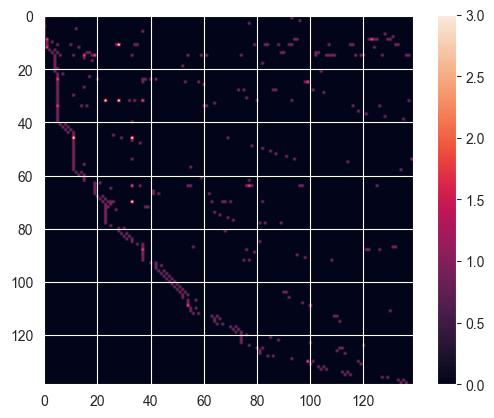

In [7]:
plt.imshow(X_ij.to_numpy())
plt.colorbar()
plt.show()

# Exercise 2 Load Glove Vectors 



The Glove vectors we are going to use are located in a text file, where each line describes one word and its associated feature vector. Formatted as such: `word float float float ...`

**1. Implement the following cell which loads the data and stores it in a *dictionary*.**
1. Open the file `glove.6B.50d.txt`
2. Iterate across each line
3. Split the line into the word and the vector
    - Numpy's `np.asarray()` function can take a string containing numbers and put them in an array
4. Insert the word as a key in the dictionary and the vector as the value

- What is the dimensionality of the data? 

In [8]:
filename = "glove.6B.50d.txt"

glove_dictionary = {}
with open(filename,'r', encoding='utf-8') as file:
    for line in tqdm(file):
        elements = line.split()
        word = elements[0]
        vector = np.asarray(elements[1:],"float32")
        glove_dictionary[word] = vector

0it [00:00, ?it/s]

In [9]:
print(glove_dictionary["have"].shape)

(50,)


## Exercise 3 - Word similarities

In this exercise you will inspect the word embedding for different words, in order to determine whether words that semantically have similar meaning (or are semantically related) also have similar representations under the embedding.

To compare two words, we use the cosine similarity score between the feature vectors representing the two words.

**1. Implement the following functions:**
   - `word_similarity` which computes the similarity of two words passed as strings, prints it if `verbose=True` and returns the similarity value
      - Create a function `cos_sim` which computes the cosine similarity of two vectors. $\text{cosine\_similarity} = 1 - \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \|\vec{B}\|}$

In [64]:
def cos_sim(v1, v2):
    return 1 - spatial.distance.cosine(v1,v2)

def word_similarity(word1, word2, verbose=True):    
    v1 = glove_dictionary[word1]
    v2 = glove_dictionary[word2]
    similarity =  cos_sim(v1,v2)
    if verbose:
        print(f"Similarity score between {word1} and {word2} = {similarity:.3f}") 
    return similarity

**2. Compare the similarity scores for the word pairs within each group.**
- Do the relative differences in scores reflect your own intuition? 
- Does this inform you about certain relations captured by the word embedding? 
- For instance, what can you learn from observing that 'Denmark' is more similar to 'Sweden' than to 'Copenhagen'?

In [11]:
#humans and family structures
word_similarity("king","queen")
word_similarity("prince","princess")
word_similarity("prince","brother")
word_similarity("princess","sister")
word_similarity("prince","sister")
word_similarity("princess","brother")
word_similarity("brother","sister")
word_similarity("brother","son")
word_similarity("sister","daughter")
word_similarity("brother","daughter")
word_similarity("sister","son")

Similarity score between king and queen = 0.784
Similarity score between prince and princess = 0.743
Similarity score between prince and brother = 0.759
Similarity score between princess and sister = 0.764
Similarity score between prince and sister = 0.591
Similarity score between princess and brother = 0.527
Similarity score between brother and sister = 0.725
Similarity score between brother and son = 0.945
Similarity score between sister and daughter = 0.893
Similarity score between brother and daughter = 0.827
Similarity score between sister and son = 0.750


In [12]:
#prepositions and orientations
word_similarity("after","before")
word_similarity("over","under")
word_similarity("vertical","horizontal")
word_similarity("left","right")

Similarity score between after and before = 0.951
Similarity score between over and under = 0.754
Similarity score between vertical and horizontal = 0.956
Similarity score between left and right = 0.781


In [13]:
#toponyms (places)
word_similarity("city","country")
word_similarity("city","town")
word_similarity("denmark","sweden")
word_similarity("denmark","copenhagen")
word_similarity("stockholm","copenhagen")
word_similarity("stockholm","denmark")
word_similarity("sweden","stockholm")
word_similarity("sweden","copenhagen")
word_similarity("walk","run")
word_similarity("run","sit")
word_similarity("walk","sit")

Similarity score between city and country = 0.667
Similarity score between city and town = 0.869
Similarity score between denmark and sweden = 0.885
Similarity score between denmark and copenhagen = 0.631
Similarity score between stockholm and copenhagen = 0.763
Similarity score between stockholm and denmark = 0.579
Similarity score between sweden and stockholm = 0.698
Similarity score between sweden and copenhagen = 0.573
Similarity score between walk and run = 0.683
Similarity score between run and sit = 0.539
Similarity score between walk and sit = 0.759


In [14]:
#Homonyms (words with different meanings)
word_similarity("second","minute")
word_similarity("first","second")
word_similarity("first","minute")

Similarity score between second and minute = 0.720
Similarity score between first and second = 0.932
Similarity score between first and minute = 0.596


**3. Implement the function `nearest_neighbours` which computes the $N$ nearest neighbours (most similar words) to a single word.**
 - Follow these steps:
    1. Create an array containing all the vectors representations of every word and one for the vectors
             - `.keys()` provides an iterable of the keys of a dictionary
             - `.values()` does the same for the values, in the same order 
    2. Compute the similarity scores using the dot product between the vector of the word and all the words in the vocabulary
    3. Find the top indices 
 - What is the top neighbour for any word?
The word itself
- Look at various words and comment on the similar words. Do you agree that they are similar?

In [15]:
def nearest_neighbours(word, num_neighbours):    
    words = np.array(list(glove_dictionary.keys()))
    vectors = np.array(list(glove_dictionary.values()))
    
    # Compute cosine similarity between the target word vector and all vectors
    v = glove_dictionary[word]
    scores = np.dot(vectors, v) / (np.linalg.norm(vectors, axis=1) * np.linalg.norm(v))
    
    # Get indices of the top scores
    top_indices = np.argsort(scores)[-num_neighbours:][::-1]
    
    # Print the most similar words with their similarity scores
    print(f"Most similar words to '{word}':")
    for idx in top_indices:
        print(f"{scores[idx]:.4f}\t{words[idx]}")  

In [16]:
nearest_neighbours("denmark", 3)
nearest_neighbours("king", 3)

Most similar words to 'denmark':
1.0000	denmark
0.8848	sweden
0.8509	norway
Most similar words to 'king':
1.0000	king
0.8236	prince
0.7839	queen


## Exercise 4 - Visualizing using PCA

In this exercise we use principal component analysis (PCA) to reduce the dimensionality of the feature vector space. This allows us to illustrate the spatial relation between different words from the vocabulary.

**1. Implement the function, `plot_pca` that conducts PCA on a sub-set of the data and projects these data-points onto the first two principal components.** 
- Follow these steps:
    1. Obtain a matrix of the vectors and transpose it
    2. Subtract the mean of each dimension (axis=1) from the matrix
    3. Compute the eigenvectors and values of the covariance matrix
    4. Project the data onto the eigenvectors. Pay attention to the dimensions in order to do the projection correctly
    5. The eigenvectors are initially sorted in ascending order, take use the dimensions corresponding to the largest eigenvalues and plot them
- Comment on any linearity and distance between pairs of words.

- When visualizing for many words, comment on which words are grouped together. Does the grouping capture any semantic meaning?

- Evaluate whether you can use the PCA visualization to illustrate your findings from the previous exercise. Can your previous intuitions be supported by the plots?

In [54]:
def plot_pca(word_list):
    #obtain dictionary of words from word_list
    vectors = np.asarray([glove_dictionary[key] for key in word_list]).T
    
    #pca on feature vectors for selected words
    mean_vector = np.mean(vectors,axis=1)
    data = vectors - mean_vector[:,None]
    #compute the covariance matrix
    S = np.cov(data)
    #obtain eigenvectors and eigenvalues
    eigen_values, eigen_vectors = eigh(S)
    #sort according to size of eigenvalues
    Y = eigen_vectors.T @ (data)    # shape = (dim_vectors, num_words)
    #plot for first two principal components
    for label, x, y in zip(word_list, Y[-1,:], Y[-2,:]):
        plt.plot(x,y,"*")
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()

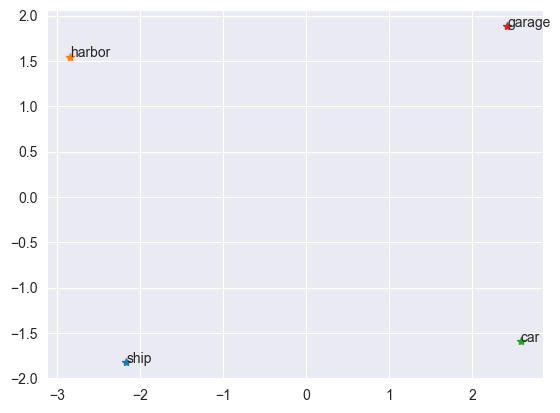

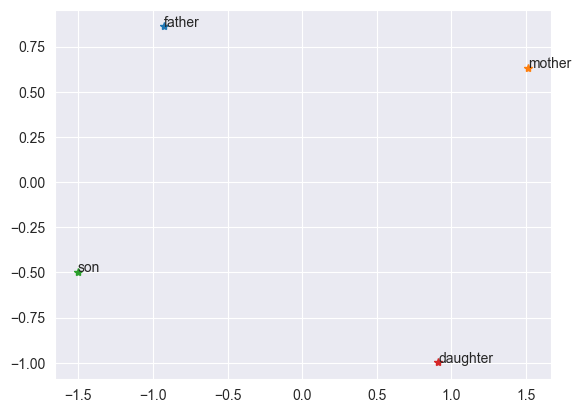

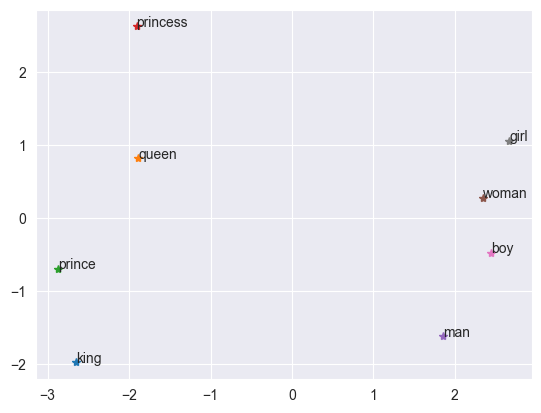

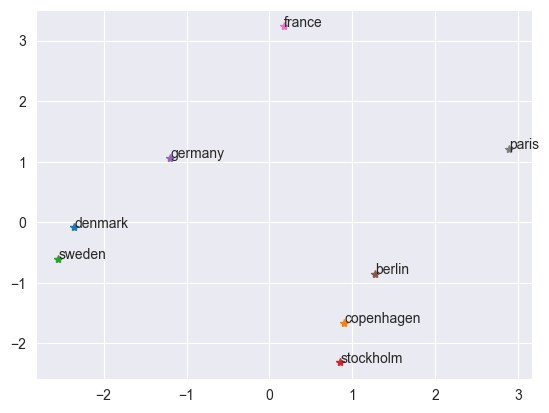

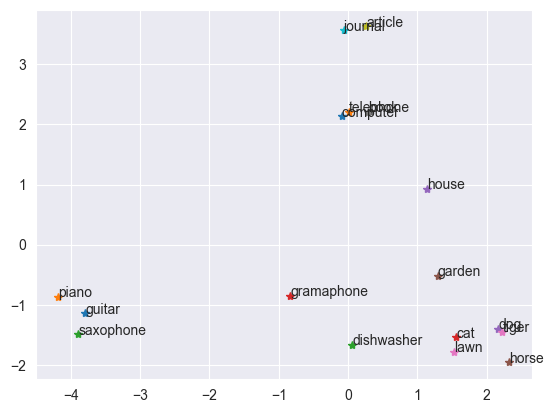

In [55]:
plot_pca(["ship","harbor","car","garage"])
plot_pca(["father","mother","son","daughter"])
plot_pca(["king","queen","prince","princess","man","woman","boy","girl"])
plot_pca(["denmark","copenhagen","sweden","stockholm","germany","berlin","france","paris"])
plot_pca(["guitar","piano","saxophone","cat","dog","horse","tiger","book","article","journal","computer","telephone","dishwasher","gramaphone","house","garden","lawn"])

## Exercise 5 - Analogy solver


As defined by Aristotle as "an equality of proportions", an analogy can be considered a problem involving four terms, such that the second term is related to the first in a similar way as the forth term is related to the third.

An example of an analogy is;
- *evening* is to *morning* as *dinner* is to *breakfast*

Analogies are often used as verbal reasoning tests, where the test subject is asked to infer the similarity between two relations, by only being presented the first three terms of the analogy problem.
For instance, the subject is expected to infer the term *girl* from the problem;
- *brother* is to *sister* as *boy* is to *???*

These kind of problems are often included in assessments of intelligence (such as IQ or children development tests) as the ability to draw analogies are believed to reflect the underlying cognitive ability to represent and reason about higher-order relations.

In this exercise you are going to examine an AI algorithm for solving such analogy problems. As input, the algorithm is given the first three terms of an analogy problem. It will then rely on the linear substructure of the GloVe word embedding to find and return the best candidate word for the forth term.

**Algorithm:**
For a given problem, let $v_1,v_2,v_3$ be the vector representations for the first three terms. 
The guess for the forth term is found as the word for which the associated vector representation is most similar to the vector $v_d = (v_3 - (v_1-v_2))$. To compare vectors, the algorithm uses the cosine similarity measure.

**1. Argue why this approach is reasonable and why $v_d$ is computed as it is.** 

*Hint: It may be easier to build intuition from considering the problem in 2D.*

**2. Implement the algorithm**
- Follow these steps:
    1. Get the vector representations for each of the 3 words and calculate the fourth vector
    2. Create a matrix of word vectors that excludes the three original words 
    3. Calculate the distances to $v_d$
        - For this, implement a cos_sim function that calculates the cosine similarity between a vector and a matrix `cos_sim_vec_mat`
    4. Return the `N` closest words and their scores
        - `np.argsort` sorts a vector in ascending order, `[::-1]` can be used to reverse the order of an array
        - To use the indexes on a list it must be converted to a numpy array

- Test the algorithm with the provided examples as well as with analogy problems of your own. Investigate whether there are particular types of analogies that the algorithm cannot solve. Comment on why this is.

In [56]:
def cos_sim_vec_mat(v1, v2):
    """Compute cosine similarity between a vector and a matrix."""
    # Normalize the vector v1
    v1_norm = v1 / np.linalg.norm(v1)

    # Normalize the matrix v2
    v2_norm = v2 / np.linalg.norm(v2, axis=1, keepdims=True)

    # Compute the cosine similarity
    similarity = np.dot(v2_norm, v1_norm)

    return similarity

In [57]:
def find_analogy(w1, w2, w3, N=1):
    # Retrieve vectors for the input words
    v1 = glove_dictionary[w1]
    v2 = glove_dictionary[w2]
    v3 = glove_dictionary[w3]
    
    # Calculate the analogy vector
    vd = v3 - (v1 - v2)
    
    # Create a list of words excluding w1, w2, w3
    words = list(glove_dictionary.keys())
    filtered_words = [word for word in words if word not in {w1, w2, w3}]
    
    # Get the vectors for the filtered words
    vectors = np.array([glove_dictionary[word] for word in filtered_words])
    
    # Calculate cosine similarities
    similarities = cos_sim_vec_mat(vd, vectors)
    
    # Find the index of the maximum similarity
    max_indexes = np.argsort(similarities)[-N:][::-1]
    
    # Return the corresponding word
    return np.array(filtered_words)[max_indexes], similarities[max_indexes]

man is to woman as doctor is to:
1: nurse: 0.842
2: child: 0.775
3: pregnant: 0.768
4: mother: 0.766
5: patient: 0.749


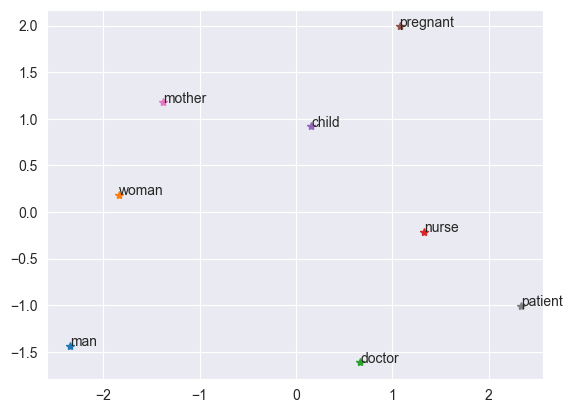

In [60]:
N = 5
#examples of analogy problems

#w1 = "man"; w2 = "woman"; w3 = "king";
#w1 = "brother"; w2 = "sister"; w3 = "boy";
#w1 = "pen"; w2 = "paper"; w3 = "doctor";
#w1 = "denmark"; w2 = "copenhagen"; w3 = "germany";
#w1 = "denmark"; w2 = "copenhagen"; w3 = "france";
#w1 = "denmark"; w2 = "france"; w3 = "copenhagen";
#w1 = "car"; w2 = "parking"; w3 = "ship";
#w1 = "left"; w2 = "right"; w3 = "horizontal";
#w1 = "woman"; w2 = "man"; w3 = "mother";
w1 = "man"; w2 = "woman"; w3 = "doctor";

w4, scores = find_analogy(w1, w2, w3, N)
print(w1, "is to", w2, "as", w3, "is to:")
for i, (word, score) in enumerate(zip(w4, scores)):
    print(f"{i+1}: {word}: {score:.3}")
plot_pca([w1,w2,w3,*w4])



**2. For real cognitive tests the analogy problem is often presented as a multiple-choice question. Modify the algorithm to such a setting** 
- Before you start, would you expect it to perform better?
- The changes that need to be made are:
1. The function must take a list of words from which to choose 
2. These must be used to create the matrix for calculating the similarities
- After implementation, does it perform better in your opinion?

In [62]:
def find_analogy_multiple_choice(w1, w2, w3, choices, N=1):
    # Retrieve vectors for the input words
    v1 = glove_dictionary[w1]
    v2 = glove_dictionary[w2]
    v3 = glove_dictionary[w3]
    
    # Calculate the analogy vector
    vd = v3 - (v1 - v2)
    # Get the vectors for the filtered words
    vectors = np.array([glove_dictionary[word] for word in choices])
    
    # Calculate cosine similarities
    similarities = cos_sim_vec_mat(vd, vectors)
    
    # Find the index of the maximum similarity
    max_indexes = np.argsort(similarities)[-N:][::-1]
    
    # Return the corresponding word
    return np.array(choices)[max_indexes], similarities[max_indexes]

man is to woman as doctor is to:
1: nurse: 0.842
2: teacher: 0.715
3: lawyer: 0.508
4: engineer: 0.415


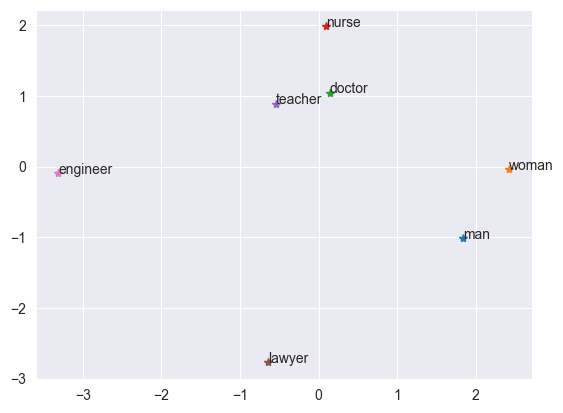

In [63]:
N = 4
# w1 = "man"; w2 = "woman"; w3 = "king"; options = ["queen", "prince", "father", "sister"]
# w1 = "brother"; w2 = "sister"; w3 = "boy"; options = ["girl", "man", "child", "parent"]
# w1 = "pen"; w2 = "paper"; w3 = "doctor"; options = ["stethoscope", "hospital", "patient", "nurse"]
# w1 = "denmark"; w2 = "copenhagen"; w3 = "germany"; options = ["berlin", "france", "sweden", "norway"]
# w1 = "denmark"; w2 = "copenhagen"; w3 = "france"; options = ["paris", "lyon", "marseille", "nice"]
# w1 = "denmark"; w2 = "france"; w3 = "copenhagen"; options = ["paris", "stockholm", "oslo", "helsinki"]
# w1 = "car"; w2 = "parking"; w3 = "ship"; options = ["dock", "garage", "boat", "plane"]
# w1 = "left"; w2 = "right"; w3 = "horizontal"; options = ["vertical", "diagonal", "up", "down"]
# w1 = "woman"; w2 = "man"; w3 = "mother"; options = ["father", "child", "sister", "parent"]
w1 = "man"; w2 = "woman"; w3 = "doctor"; options = ["nurse", "teacher", "engineer", "lawyer"]

w4, scores = find_analogy_multiple_choice(w1, w2, w3, choices=options, N=N)
print(w1, "is to", w2, "as", w3, "is to:")
for i, (word, score) in enumerate(zip(w4, scores)):
    print(f"{i+1}: {word}: {score:.3}")
plot_pca([w1,w2,w3,*w4])

## Exercise 6 - Quantifying stereotypes

As for most machine learning algorithms, word embedding can be proned to biases. If the original data contained systematic biases, the learned representations may also reflect these biases. The GloVe machine learning algorithm was trained on Wikipedia texts. If these texts in general contained or described specific stereotypes, the word embedding will also capture these stereotypes. 
Often it is found that word embeddings contain gender stereotypes, often significantly with regards to professions.

**1. In the above exercises we have used the plot_pca function to visualize the words "nurse", "doctor", "man" and "woman". Comment on the plots in terms of gender stereotypes.**

**2. Compare the cosine distance between various professions ("programmer", "secretary", "pilot", "president", "nurse",...) and the words "mother" and "farther". Comment on your findings.**


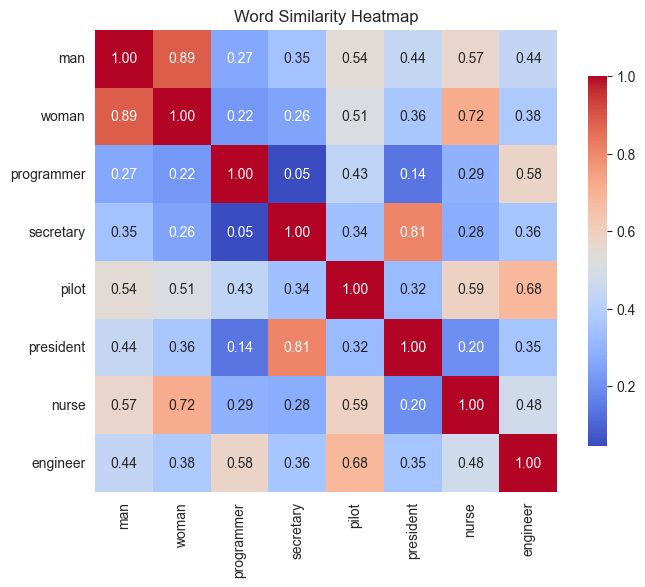

In [74]:
import seaborn as sns

# Define the words for which you want to compute similarities
words = ["man", "woman", "programmer", "secretary", "pilot", "president", "nurse", "engineer",]

# Create a similarity matrix
similarity_matrix = np.zeros((len(words), len(words)))

for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        similarity_matrix[i, j] = word_similarity(word1, word2, verbose=False)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Word Similarity Heatmap')
plt.show()

**3. Evaluate terms that relate to the two words "man" and "woman" by comparing the nearest neighbours to "man" and "woman" respectively. Are there any professions related to "man" and "woman"? Do "man" and "woman" have neighbours in common?**


In [72]:
nearest_neighbours("woman", 15)

Most similar words to 'woman':
1.0000	woman
0.9065	girl
0.8860	man
0.8764	mother
0.8613	her
0.8596	boy
0.8431	she
0.8225	herself
0.8108	child
0.8037	wife
0.7982	old
0.7976	victim
0.7936	husband
0.7868	person
0.7832	grandmother


In [73]:
nearest_neighbours("man", 15)

Most similar words to 'man':
1.0000	man
0.8860	woman
0.8564	boy
0.8453	another
0.8372	old
0.8276	one
0.8245	who
0.8195	him
0.8154	turned
0.8120	whose
0.8077	himself
0.8053	his
0.8051	a
0.7960	friend
0.7957	she


**4. Based on your findings, discuss whether you can use the analogy solver to test for various biases or stereotypes that may have been conveyed to the word embedding.**

**5. Reflect on whether word embedding in general is a feasible approach to verify if a text corpus contains biases or stereotypes.**
